In [1]:
%load_ext autoreload
%autoreload 2

from time import time
import pandas as pd
import numpy as np
import os
from collections import Counter, defaultdict
import pickle

In [2]:
import sys
sys.path.insert(0, "/data3/muntean/DRhard")

In [3]:
import argparse
import subprocess
import sys
sys.path.append("./")
import faiss
import logging
import os
import numpy as np
# import torch
from transformers import RobertaConfig
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SequentialSampler

from model import RobertaDot
from dataset import (
    TextTokenIdsCache, load_rel, SubsetSeqDataset, SequenceDataset,
    single_get_collate_function
)
from retrieve_utils import (
    construct_flatindex_from_embeddings, 
    index_retrieve, convert_index_to_gpu
)
logger = logging.Logger(__name__)

/data3/muntean/DRhard/DRhard/lib/python3.8/site-packages/torch-1.7.0-py3.8-linux-x86_64.egg/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
doc_memmap_path = "/data3/muntean/DRhard/data/passage/evaluate/star/passages.memmap"
docid_memmap_path = "/data3/muntean/DRhard/data/passage/evaluate/star/passages-id.memmap"
query_memmap_path = "/data3/muntean/DRhard/data/passage/evaluate/star/test-manual-query.memmap"
queryids_memmap_path = "/data3/muntean/DRhard/data/passage/evaluate/star/test-manual-query-id.memmap"

# query_adore_memmap_path = "/data3/muntean/DRhard/data/passage/evaluate/adore-star/test-manual.qembed.memmap"

In [5]:
doc_embeddings = np.memmap(doc_memmap_path, dtype=np.float32, mode="r")
doc_ids = np.memmap(docid_memmap_path, dtype=np.int32, mode="r")
doc_embeddings = doc_embeddings.reshape(-1, 768)

query_embeddings = np.memmap(query_memmap_path, dtype=np.float32, mode="r")
query_embeddings = query_embeddings.reshape(-1, 768)
query_ids = np.memmap(queryids_memmap_path, dtype=np.int32, mode="r")

In [6]:
%time
index = construct_flatindex_from_embeddings(doc_embeddings, doc_ids)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10.5 µs
embedding shape: (38626614, 768)
(38626614,) int64


In [7]:
type(index)

faiss.swigfaiss.IndexIDMap2

# Select certain queries and certain docs for small index

In [8]:
# Load our qid and docid remapping dictionaries

# query id dict
qid_mapping_path = "/data3/muntean/DRhard/data/passage/dataset/queries.CASTmanual.QID2newID.test.tsv"
queries_df = pd.read_csv(qid_mapping_path, delimiter="\t", header=None)
print(len(queries_df))

# collection id dict
collection_mapping_path = "/data3/muntean/DRhard/data/passage/dataset/CASTcollectionPID2newID.tsv"
collection_df = pd.read_csv(collection_mapping_path, delimiter="\t", header=None)
print(len(collection_df))

479
38626614


In [9]:
qid2newqid_dict = dict(zip(queries_df[0], queries_df[1])) 
pid2newpid_dict = dict(zip(collection_df[0], collection_df[1])) 

In [10]:
qid2newqid_dict["32_1"]

9

In [11]:
# Create reverse dictionaries
newqid2qid_dict = dict(zip(queries_df[1], queries_df[0])) 
newpid2pid_dict = dict(zip(collection_df[1], collection_df[0])) 

In [12]:
newqid2qid_dict[9]

'32_1'

In [13]:
# DRhard docid and qid encoding
preprocess_dir = "/data3/muntean/DRhard/data/passage/preprocess"

pid2offset = pickle.load(open(os.path.join(preprocess_dir, "pid2offset.pickle"), 'rb'))
offset2pid = {v:k for k, v in pid2offset.items()}
qid2offset = pickle.load(open(os.path.join(preprocess_dir, f"test-manual-qid2offset.pickle"), 'rb'))
offset2qid = {v:k for k, v in qid2offset.items()}

In [14]:
qid2offset[9]

9

In [15]:
conv_qrel_int = [31, 32, 33, 34, 37, 40, 49, 50, 54, 56, 58, 59, 61, 67, 68, 69, 75, 77, 78, 79]
conv_qrel = [str(x) for x in conv_qrel_int]
conv_qrel

['31',
 '32',
 '33',
 '34',
 '37',
 '40',
 '49',
 '50',
 '54',
 '56',
 '58',
 '59',
 '61',
 '67',
 '68',
 '69',
 '75',
 '77',
 '78',
 '79']

# Compute all possible distances in cache!!!

In [18]:
all_dist_dict = {}
qa_qb_dist = {}
for convid in conv_qrel:
    print(convid)
    # qa
    first_qid = convid + "_1"
    first_newqid = qid2newqid_dict[first_qid] #added first
    first_qid_offset = qid2offset[first_newqid]
    print(first_qid, first_qid_offset)

    # prendere il memmap
    first_query_emb = query_embeddings[first_qid_offset].reshape(1, 768)
    
    # fare retireval nel indice grande e prendere top 10000 documenti
    faiss.omp_set_num_threads(16) #32
    nearest_neighbors_ra = index_retrieve(index, first_query_emb, 10000, batch=32)
    print(len(nearest_neighbors_ra[0]))

    # compute dist between q_1 and all retrieved docs
    q_p_dist_list = []
    for docid in nearest_neighbors_ra[0]:
        doc_emb = doc_embeddings[docid].reshape(1, 768)
        
        q_p_dist = l2_distance(query_emb, doc_emb)
        q_p_dist_list.append(q_p_dist)
    
    all_dist_dict[first_qid] = q_p_dist_list
    print(len(q_p_dist_list))
    
    ### compute dist between all other q in the same conv and all retrieved docs
    # get conv ids
    conv_qids = [qid for qid in qid2newqid_dict.keys() if qid.startswith(convid+"_") and not qid.endswith("_1")]
    print(conv_qids)
    
    # get qid emb
    for qid in conv_qids:
        newqid = qid2newqid_dict[qid] #added first
        qid_offset = qid2offset[newqid]
        print(qid, qid_offset)
        # the header are the docids, the index the queryids
        query_emb = query_embeddings[qid_offset].reshape(1, 768)
        
        #qa qb dist
        qa_qb_dist[qid] = l2_distance(first_query_emb, query_emb)
        
        # query doc dist
        q_p_dist_list = []
        for docid in nearest_neighbors_ra[0]:
            doc_emb = doc_embeddings[docid].reshape(1, 768)

            q_p_dist = l2_distance(query_emb, doc_emb)
            q_p_dist_list.append(q_p_dist)
        
        all_dist_dict[qid] = q_p_dist_list

31
31_1 0
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.40s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63404.6ms
10000
10000
['31_2', '31_3', '31_4', '31_5', '31_6', '31_7', '31_8', '31_9']
31_2 1
31_3 2
31_4 3
31_5 4
31_6 5
31_7 6
31_8 7
31_9 8
32
32_1 9
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.04s/it]


Elapsed Time: 37.0s, Elapsed Time per query: 37046.8ms
10000
10000
['32_2', '32_3', '32_4', '32_5', '32_6', '32_7', '32_8', '32_9', '32_10', '32_11']
32_2 10
32_3 11
32_4 12
32_5 13
32_6 14
32_7 15
32_8 16
32_9 17
32_10 18
32_11 19
33
33_1 20
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:55<00:00, 55.19s/it]


Elapsed Time: 55.2s, Elapsed Time per query: 55194.6ms
10000
10000
['33_2', '33_3', '33_4', '33_5', '33_6', '33_7', '33_8', '33_9', '33_10']
33_2 21
33_3 22
33_4 23
33_5 24
33_6 25
33_7 26
33_8 27
33_9 28
33_10 29
34
34_1 30
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.44s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63443.2ms
10000
10000
['34_2', '34_3', '34_4', '34_5', '34_6', '34_7', '34_8', '34_9']
34_2 31
34_3 32
34_4 33
34_5 34
34_6 35
34_7 36
34_8 37
34_9 38
37
37_1 59
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.49s/it]


Elapsed Time: 60.5s, Elapsed Time per query: 60490.7ms
10000
10000
['37_2', '37_3', '37_4', '37_5', '37_6', '37_7', '37_8', '37_9', '37_10', '37_11', '37_12']
37_2 60
37_3 61
37_4 62
37_5 63
37_6 64
37_7 65
37_8 66
37_9 67
37_10 68
37_11 69
37_12 70
40
40_1 88
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.21s/it]


Elapsed Time: 32.2s, Elapsed Time per query: 32216.9ms
10000
10000
['40_2', '40_3', '40_4', '40_5', '40_6', '40_7', '40_8', '40_9', '40_10']
40_2 89
40_3 90
40_4 91
40_5 92
40_6 93
40_7 94
40_8 95
40_9 96
40_10 97
49
49_1 165
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.42s/it]


Elapsed Time: 62.4s, Elapsed Time per query: 62421.4ms
10000
10000
['49_2', '49_3', '49_4', '49_5', '49_6', '49_7', '49_8', '49_9', '49_10']
49_2 166
49_3 167
49_4 168
49_5 169
49_6 170
49_7 171
49_8 172
49_9 173
49_10 174
50
50_1 175
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.35s/it]


Elapsed Time: 62.4s, Elapsed Time per query: 62353.5ms
10000
10000
['50_2', '50_3', '50_4', '50_5', '50_6', '50_7', '50_8', '50_9', '50_10']
50_2 176
50_3 177
50_4 178
50_5 179
50_6 180
50_7 181
50_8 182
50_9 183
50_10 184
54
54_1 214
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.75s/it]


Elapsed Time: 60.7s, Elapsed Time per query: 60748.9ms
10000
10000
['54_2', '54_3', '54_4', '54_5', '54_6', '54_7', '54_8', '54_9']
54_2 215
54_3 216
54_4 217
54_5 218
54_6 219
54_7 220
54_8 221
54_9 222
56
56_1 233
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:57<00:00, 57.18s/it]


Elapsed Time: 57.2s, Elapsed Time per query: 57181.8ms
10000
10000
['56_2', '56_3', '56_4', '56_5', '56_6', '56_7', '56_8']
56_2 234
56_3 235
56_4 236
56_5 237
56_6 238
56_7 239
56_8 240
58
58_1 251
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.16s/it]


Elapsed Time: 33.2s, Elapsed Time per query: 33164.9ms
10000
10000
['58_2', '58_3', '58_4', '58_5', '58_6', '58_7', '58_8']
58_2 252
58_3 253
58_4 254
58_5 255
58_6 256
58_7 257
58_8 258
59
59_1 259
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.63s/it]


Elapsed Time: 63.6s, Elapsed Time per query: 63631.2ms
10000
10000
['59_2', '59_3', '59_4', '59_5', '59_6', '59_7', '59_8']
59_2 260
59_3 261
59_4 262
59_5 263
59_6 264
59_7 265
59_8 266
61
61_1 274
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.07s/it]


Elapsed Time: 61.1s, Elapsed Time per query: 61070.0ms
10000
10000
['61_2', '61_3', '61_4', '61_5', '61_6', '61_7', '61_8', '61_9']
61_2 275
61_3 276
61_4 277
61_5 278
61_6 279
61_7 280
61_8 281
61_9 282
67
67_1 334
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.15s/it]


Elapsed Time: 58.1s, Elapsed Time per query: 58148.6ms
10000
10000
['67_2', '67_3', '67_4', '67_5', '67_6', '67_7', '67_8', '67_9', '67_10', '67_11']
67_2 335
67_3 336
67_4 337
67_5 338
67_6 339
67_7 340
67_8 341
67_9 342
67_10 343
67_11 344
68
68_1 345
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.76s/it]


Elapsed Time: 31.8s, Elapsed Time per query: 31764.2ms
10000
10000
['68_2', '68_3', '68_4', '68_5', '68_6', '68_7', '68_8', '68_9', '68_10', '68_11']
68_2 346
68_3 347
68_4 348
68_5 349
68_6 350
68_7 351
68_8 352
68_9 353
68_10 354
68_11 355
69
69_1 356
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.25s/it]


Elapsed Time: 61.2s, Elapsed Time per query: 61249.8ms
10000
10000
['69_2', '69_3', '69_4', '69_5', '69_6', '69_7', '69_8', '69_9', '69_10']
69_2 357
69_3 358
69_4 359
69_5 360
69_6 361
69_7 362
69_8 363
69_9 364
69_10 365
75
75_1 420
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.98s/it]


Elapsed Time: 60.0s, Elapsed Time per query: 59982.9ms
10000
10000
['75_2', '75_3', '75_4', '75_5', '75_6', '75_7', '75_8', '75_9', '75_10']
75_2 421
75_3 422
75_4 423
75_5 424
75_6 425
75_7 426
75_8 427
75_9 428
75_10 429
77
77_1 440
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.99s/it]


Elapsed Time: 60.0s, Elapsed Time per query: 59988.0ms
10000
10000
['77_2', '77_3', '77_4', '77_5', '77_6', '77_7', '77_8', '77_9', '77_10']
77_2 441
77_3 442
77_4 443
77_5 444
77_6 445
77_7 446
77_8 447
77_9 448
77_10 449
78
78_1 450
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.23s/it]


Elapsed Time: 59.2s, Elapsed Time per query: 59230.7ms
10000
10000
['78_2', '78_3', '78_4', '78_5', '78_6', '78_7', '78_8', '78_9', '78_10']
78_2 451
78_3 452
78_4 453
78_5 454
78_6 455
78_7 456
78_8 457
78_9 458
78_10 459
79
79_1 460
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.31s/it]


Elapsed Time: 29.3s, Elapsed Time per query: 29318.0ms
10000
10000
['79_2', '79_3', '79_4', '79_5', '79_6', '79_7', '79_8', '79_9']
79_2 461
79_3 462
79_4 463
79_5 464
79_6 465
79_7 466
79_8 467
79_9 468


In [19]:
#### Saving variables
%store all_dist_dict
%store nearest_neighbors_ra
%store qa_qb_dist

Stored 'all_dist_dict' (dict)
Stored 'nearest_neighbors_ra' (list)
Stored 'qa_qb_dist' (dict)


In [21]:
# #check rb_hat
# rb_hat_10000 = {}
# for qid in conv_qids:
#     print(qid)
#     rb_hat = all_dist_dict["31_1"][9999] - query_distance_dict[qid]
#     print(all_dist_dict["31_1"][9999], query_distance_dict[qid], rb_hat)
#     rb_hat_10000[qid]= rb_hat

In [22]:
# # check how many in q_p_dist_list of each are less than the rb_hat radius

# for qid in ["31_6"]:# conv_qids:
#     distances = all_dist_dict[qid]
#     safe_dist_docs = ([(i,dist) for (i,dist) in enumerate(distances) if dist < 3 ])# rb_hat_10000[qid]])
#     print(qid, safe_dist_docs)

In [24]:
# # check how many in q_p_dist_list of each are less than the rb_hat radius
# distances_qa = all_dist_dict["31_1"]
# distances_qb = all_dist_dict["31_6"]
# assert len(distances_qa)==len(distances_qb)
# for (i,dist) in enumerate(distances_qb):
#     assert distances_qb[i] <= distances_qa[i] + query_distance_dict["31_6"]

In [105]:
# all_dist_dict["31_6"]

In [ ]:
# numpy_data = np.array(all_dist_list)
# dist_df = pd.DataFrame(data=numpy_data, index=query_ids, columns=doc_ids)

In [ ]:
# %store dist_df

# Create conv cache

In [23]:
topk = 10000 # cache dimension [1000,2000,5000,10000]
# evaluation is done on top 1000 - another topk?

In [24]:
# distance dicts

cache_radius_dict = dict() # between first utterance (qa) and last retrieved doc from the big index
query_distance_dict = dict() # distance between the first (qa) and the rest of utterances of the conversation (qb)
query_radius_dict = dict() # between current utterance (qb) and last retrieved doc from the big index
diff_distance_dict = dict() # rb_hat = ra - d(qb, qa)

In [25]:
def l2_distance(v1,v2):
    return np.linalg.norm(v1-v2)

In [26]:
def create_conv_cache(conv_id, qid2newqid_dict, qid2offset, query_embeddings, doc_embeddings, 
                      index, topk, cache_radius_dict):
    # first utt of the conversation - determines the size of the cache
    first_qid = conv_id + "_1"
    newqid = qid2newqid_dict[first_qid] #added first
    qid_offset = qid2offset[newqid]

    # prendere il memmap
    query_emb = query_embeddings[qid_offset].reshape(1, 768)
    
    # fare retireval nel indice grande e prendere top 2000 documenti
    faiss.omp_set_num_threads(16) #32
    nearest_neighbors = index_retrieve(index, query_emb, topk, batch=32)
    
    # select doc embeddings, paired with ids
    small_doc_emb = doc_embeddings[nearest_neighbors[0]]
    small_doc_ids = np.array(nearest_neighbors[0])
    index_conv = construct_flatindex_from_embeddings(small_doc_emb, small_doc_ids)
       
    # compute distance between the first query and last doc in the list of topk retrieved that are stored in cache (e.g., r_q_i)
    last_doc = nearest_neighbors[0][-1]
    last_doc_embedding = doc_embeddings[last_doc]
    cache_radius_dict[first_qid] = l2_distance(query_emb, last_doc_embedding)
    
    return index_conv, nearest_neighbors, cache_radius_dict

In [ ]:
# conv_ids = set([x.split("_")[0] for x in qid2newqid_dict.keys()]) # this has all but we don't need all, just the ones in qrel
# conv in qrel: subset of all conv
conv_qrel_int = [31, 32, 33, 34, 37, 40, 49, 50, 54, 56, 58, 59, 61, 67, 68, 69, 75, 77, 78, 79]
conv_qrel = [str(x) for x in conv_qrel_int]


results_list = []  # top1000 rankings for each query of the conversation from the CACHE index
coverage1 = {} # top10 ranking for each query from the BIG index
coverage2 = {} # list of triples (3,5,10) for each qb

for conv_id in conv_qrel: # iterate over the conversations
    
    print("Starting conv: " , conv_id)
    
    # ALL QA
    # Create index for first query and retrieve nearest neighbours - top 2000
    index_conv, nearest_neighbors, cache_radius_dict = create_conv_cache(conv_id, qid2newqid_dict, 
                                                                         qid2offset, query_embeddings, 
                                                                         doc_embeddings, index, topk, 
                                                                         cache_radius_dict)
    print("Create cache for: ", conv_id)
    
    # save docs for qa for coverage
    retrieved_qa = nearest_neighbors[0]
        
    # first  query id & embedding
    first_qid = conv_id + "_1"
    first_newqid = qid2newqid_dict[first_qid] #added first
    first_qid_offset = qid2offset[first_newqid]
    
    # save results - top 1000 for first conv query qa
    for idx, pid in enumerate(nearest_neighbors[0][:1000]):
        results_list.append((first_qid_offset, pid, idx+1))
    
    # prendere il memmap di qa
    first_query_emb = query_embeddings[first_qid_offset].reshape(1, 768)
    
    # for each utt in the rest of the conv: qb
    for qid in qid2newqid_dict.keys():
        if not qid.endswith("_1") and qid.startswith(conv_id):
            print("Processing qid:", qid)
            # select query embedding
            newqid = qid2newqid_dict[qid]
            qid_offset = qid2offset[newqid]
            # prendere il memmap
            query_emb = query_embeddings[qid_offset].reshape(1, 768)
            
            # retrieve docs for qb
            faiss.omp_set_num_threads(16) #32
            nearest_neighbors = index_retrieve(index_conv, query_emb, 1000, batch=32)
            print("Retrieved top 1000 for", qid)
            
            # save results - top1000, for qb
            for idx, pid in enumerate(nearest_neighbors[0]):
                results_list.append((qid_offset, pid, idx+1))
            
            print("Computing distances and coverage!")
            #### Compute DISTANCES rb_hat
            
            # compute distance between qb and qa
            query_distance_dict[qid] = l2_distance(query_emb, first_query_emb)
            
            # compute rb_capuccio = ra - d(qb, qa)
            diff_distance_dict[qid] = cache_radius_dict[first_qid] - query_distance_dict[qid]
            
            #### Compute COVERAGE 
            # Cov1 - intersezione tra Ba ed Bb_hat
            # distance between qb and each doc in top1000 from cache and check if < rb_hat
            # put them in a list - exact match - and intersect with top k in cache
            retrieved_qb_in_rb_hat = []
            small_doc_emb = doc_embeddings[nearest_neighbors[0]]
            for doc_id, doc_emb in zip(nearest_neighbors[0], small_doc_emb):
                if l2_distance(query_emb, doc_emb) < diff_distance_dict[qid]:
                    retrieved_qb_in_rb_hat.append(doc_id)
            coverage1[qid]=len(retrieved_qb_in_rb_hat)
            print("Finished for Rb hat!")
            
            #### Compute DISTANCES rb
            
            #compute distance between qb and the last retrieved doc from INDEX
            first_10_docs = index_retrieve(index, query_emb, 10, batch=32)
            # 3 raggi rb per 3,5,10
            rb_dist_list = []
            for i in [3,5,10]:
                last_doc_embedding = doc_embeddings[first_10_docs[0][i-1]]
                dist_rb = l2_distance(query_emb, last_doc_embedding)
                rb_dist_list.append(dist_rb)
            query_radius_dict[qid] = rb_dist_list
            print("Finished retrieving in the big index!")
            
            # save top10 for qb in INDEX
            results_list_rb= first_10_docs[0][:10]
            result_list_qb_in_cache = nearest_neighbors[0][:10]
        
            #### Compute COVERAGE          
            # Cov2 - intersezione tra risultati di query qb top 1000 su cache e query qb su indice per k=3,5,10
            num_intersection = []
            for cut_off in [3,5,10]:
                elem_in_common = set(results_list_rb[:cut_off]).intersection(result_list_qb_in_cache[:cut_off])
                num_intersection.append(len(elem_in_common))
            coverage2[qid] = num_intersection
            
            print("finished with qid: ", qid)

Starting conv:  31
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.66s/it]


Elapsed Time: 62.7s, Elapsed Time per query: 62659.1ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  31
Processing qid: 31_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.27it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.4ms
Retrieved top 1000 for 31_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.79s/it]


Elapsed Time: 62.8s, Elapsed Time per query: 62795.0ms
Finished retrieving in the big index!
finished with qid:  31_2
Processing qid: 31_3
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.70it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 25.4ms
Retrieved top 1000 for 31_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.64s/it]


Elapsed Time: 33.6s, Elapsed Time per query: 33640.9ms
Finished retrieving in the big index!
finished with qid:  31_3
Processing qid: 31_4
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.73it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.1ms
Retrieved top 1000 for 31_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.63s/it]


Elapsed Time: 58.6s, Elapsed Time per query: 58633.2ms
Finished retrieving in the big index!
finished with qid:  31_4
Processing qid: 31_5
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.36it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 23.3ms
Retrieved top 1000 for 31_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.47s/it]


Elapsed Time: 63.5s, Elapsed Time per query: 63468.6ms
Finished retrieving in the big index!
finished with qid:  31_5
Processing qid: 31_6
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.98it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 22.7ms
Retrieved top 1000 for 31_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.85s/it]


Elapsed Time: 28.9s, Elapsed Time per query: 28853.8ms
Finished retrieving in the big index!
finished with qid:  31_6
Processing qid: 31_7
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.71it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.4ms
Retrieved top 1000 for 31_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.34s/it]


Elapsed Time: 63.3s, Elapsed Time per query: 63339.7ms
Finished retrieving in the big index!
finished with qid:  31_7
Processing qid: 31_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.03it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 23.4ms
Retrieved top 1000 for 31_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.42s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63425.7ms
Finished retrieving in the big index!
finished with qid:  31_8
Processing qid: 31_9
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.81it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 23.4ms
Retrieved top 1000 for 31_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.77s/it]


Elapsed Time: 35.8s, Elapsed Time per query: 35772.6ms
Finished retrieving in the big index!
finished with qid:  31_9
Starting conv:  32
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.80s/it]


Elapsed Time: 56.8s, Elapsed Time per query: 56803.2ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  32
Processing qid: 32_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.70it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.4ms
Retrieved top 1000 for 32_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.34s/it]


Elapsed Time: 63.3s, Elapsed Time per query: 63345.9ms
Finished retrieving in the big index!
finished with qid:  32_2
Processing qid: 32_3
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.02it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 21.1ms
Retrieved top 1000 for 32_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.41s/it]


Elapsed Time: 31.4s, Elapsed Time per query: 31407.6ms
Finished retrieving in the big index!
finished with qid:  32_3
Processing qid: 32_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.33it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 14.0ms
Retrieved top 1000 for 32_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.40s/it]


Elapsed Time: 61.4s, Elapsed Time per query: 61397.2ms
Finished retrieving in the big index!
finished with qid:  32_4
Processing qid: 32_5
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.33it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 22.6ms
Retrieved top 1000 for 32_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.12s/it]


Elapsed Time: 63.1s, Elapsed Time per query: 63122.4ms
Finished retrieving in the big index!
finished with qid:  32_5
Processing qid: 32_6
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.62it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 21.0ms
Retrieved top 1000 for 32_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.29s/it]


Elapsed Time: 29.3s, Elapsed Time per query: 29288.8ms
Finished retrieving in the big index!
finished with qid:  32_6
Processing qid: 32_7
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.94it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.0ms
Retrieved top 1000 for 32_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.50s/it]


Elapsed Time: 63.5s, Elapsed Time per query: 63503.0ms
Finished retrieving in the big index!
finished with qid:  32_7
Processing qid: 32_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.08it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 20.2ms
Retrieved top 1000 for 32_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.38s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63385.4ms
Finished retrieving in the big index!
finished with qid:  32_8
Processing qid: 32_9
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.35it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 20.6ms
Retrieved top 1000 for 32_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.33s/it]


Elapsed Time: 29.3s, Elapsed Time per query: 29328.3ms
Finished retrieving in the big index!
finished with qid:  32_9
Processing qid: 32_10
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.12it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.2ms
Retrieved top 1000 for 32_10
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.53s/it]


Elapsed Time: 63.5s, Elapsed Time per query: 63533.2ms
Finished retrieving in the big index!
finished with qid:  32_10
Processing qid: 32_11
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.33it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 20.0ms
Retrieved top 1000 for 32_11
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.91s/it]


Elapsed Time: 60.9s, Elapsed Time per query: 60915.2ms
Finished retrieving in the big index!
finished with qid:  32_11
Starting conv:  33
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.46s/it]


Elapsed Time: 35.5s, Elapsed Time per query: 35465.7ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  33
Processing qid: 33_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.18it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.4ms
Retrieved top 1000 for 33_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:54<00:00, 54.80s/it]


Elapsed Time: 54.8s, Elapsed Time per query: 54799.9ms
Finished retrieving in the big index!
finished with qid:  33_2
Processing qid: 33_3
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.46it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 22.4ms
Retrieved top 1000 for 33_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.42s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63422.1ms
Finished retrieving in the big index!
finished with qid:  33_3
Processing qid: 33_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.02it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 23.4ms
Retrieved top 1000 for 33_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.74s/it]


Elapsed Time: 30.7s, Elapsed Time per query: 30743.1ms
Finished retrieving in the big index!
finished with qid:  33_4
Processing qid: 33_5
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 107.33it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.8ms
Retrieved top 1000 for 33_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.52s/it]


Elapsed Time: 60.5s, Elapsed Time per query: 60518.5ms
Finished retrieving in the big index!
finished with qid:  33_5
Processing qid: 33_6
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.96it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 23.6ms
Retrieved top 1000 for 33_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.40s/it]


Elapsed Time: 62.4s, Elapsed Time per query: 62404.9ms
Finished retrieving in the big index!
finished with qid:  33_6
Processing qid: 33_7
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.97it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 24.7ms
Retrieved top 1000 for 33_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.28s/it]


Elapsed Time: 61.3s, Elapsed Time per query: 61285.2ms
Finished retrieving in the big index!
finished with qid:  33_7
Processing qid: 33_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.07it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 25.9ms
Retrieved top 1000 for 33_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:55<00:00, 55.61s/it]


Elapsed Time: 55.6s, Elapsed Time per query: 55610.3ms
Finished retrieving in the big index!
finished with qid:  33_8
Processing qid: 33_9
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.45it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.5ms
Retrieved top 1000 for 33_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.90s/it]


Elapsed Time: 34.9s, Elapsed Time per query: 34899.7ms
Finished retrieving in the big index!
finished with qid:  33_9
Processing qid: 33_10
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.01it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 22.9ms
Retrieved top 1000 for 33_10
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.28s/it]


Elapsed Time: 63.3s, Elapsed Time per query: 63281.9ms
Finished retrieving in the big index!
finished with qid:  33_10
Starting conv:  34
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.68s/it]


Elapsed Time: 31.7s, Elapsed Time per query: 31681.7ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  34
Processing qid: 34_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.58it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.4ms
Retrieved top 1000 for 34_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.99s/it]


Elapsed Time: 61.0s, Elapsed Time per query: 60987.6ms
Finished retrieving in the big index!
finished with qid:  34_2
Processing qid: 34_3
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.22it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 23.3ms
Retrieved top 1000 for 34_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.67s/it]


Elapsed Time: 62.7s, Elapsed Time per query: 62670.6ms
Finished retrieving in the big index!
finished with qid:  34_3
Processing qid: 34_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.38it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 17.6ms
Retrieved top 1000 for 34_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.87s/it]


Elapsed Time: 28.9s, Elapsed Time per query: 28871.4ms
Finished retrieving in the big index!
finished with qid:  34_4
Processing qid: 34_5
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.90it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 10.2ms
Retrieved top 1000 for 34_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.49s/it]


Elapsed Time: 58.5s, Elapsed Time per query: 58489.5ms
Finished retrieving in the big index!
finished with qid:  34_5
Processing qid: 34_6
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.49it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 18.3ms
Retrieved top 1000 for 34_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.06s/it]


Elapsed Time: 58.1s, Elapsed Time per query: 58057.2ms
Finished retrieving in the big index!
finished with qid:  34_6
Processing qid: 34_7
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.97it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 17.5ms
Retrieved top 1000 for 34_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.50s/it]


Elapsed Time: 58.5s, Elapsed Time per query: 58499.9ms
Finished retrieving in the big index!
finished with qid:  34_7
Processing qid: 34_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.97it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 19.5ms
Retrieved top 1000 for 34_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.26s/it]


Elapsed Time: 59.3s, Elapsed Time per query: 59257.6ms
Finished retrieving in the big index!
finished with qid:  34_8
Processing qid: 34_9
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.54it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 18.7ms
Retrieved top 1000 for 34_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.28s/it]


Elapsed Time: 59.3s, Elapsed Time per query: 59280.4ms
Finished retrieving in the big index!
finished with qid:  34_9
Starting conv:  37
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.17s/it]


Elapsed Time: 61.2s, Elapsed Time per query: 61171.8ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  37
Processing qid: 37_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 106.04it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.9ms
Retrieved top 1000 for 37_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.24s/it]


Elapsed Time: 29.2s, Elapsed Time per query: 29238.5ms
Finished retrieving in the big index!
finished with qid:  37_2
Processing qid: 37_3
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 108.09it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.5ms
Retrieved top 1000 for 37_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.35s/it]


Elapsed Time: 63.3s, Elapsed Time per query: 63348.6ms
Finished retrieving in the big index!
finished with qid:  37_3
Processing qid: 37_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.48it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 22.9ms
Retrieved top 1000 for 37_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.72s/it]


Elapsed Time: 59.7s, Elapsed Time per query: 59726.6ms
Finished retrieving in the big index!
finished with qid:  37_4
Processing qid: 37_5
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.11it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.1ms
Retrieved top 1000 for 37_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.37s/it]


Elapsed Time: 32.4s, Elapsed Time per query: 32375.1ms
Finished retrieving in the big index!
finished with qid:  37_5
Processing qid: 37_6
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.46it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 25.1ms
Retrieved top 1000 for 37_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.35s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63350.2ms
Finished retrieving in the big index!
finished with qid:  37_6
Processing qid: 37_7
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.44it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 23.1ms
Retrieved top 1000 for 37_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.66s/it]


Elapsed Time: 32.7s, Elapsed Time per query: 32657.7ms
Finished retrieving in the big index!
finished with qid:  37_7
Processing qid: 37_8
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.35it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.4ms
Retrieved top 1000 for 37_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.71s/it]


Elapsed Time: 59.7s, Elapsed Time per query: 59709.0ms
Finished retrieving in the big index!
finished with qid:  37_8
Processing qid: 37_9
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.11it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 22.6ms
Retrieved top 1000 for 37_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.19s/it]


Elapsed Time: 61.2s, Elapsed Time per query: 61190.2ms
Finished retrieving in the big index!
finished with qid:  37_9
Processing qid: 37_10
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.62it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 22.3ms
Retrieved top 1000 for 37_10
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.26s/it]


Elapsed Time: 61.3s, Elapsed Time per query: 61261.7ms
Finished retrieving in the big index!
finished with qid:  37_10
Processing qid: 37_11
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.30it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 22.9ms
Retrieved top 1000 for 37_11
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.14s/it]


Elapsed Time: 29.1s, Elapsed Time per query: 29141.7ms
Finished retrieving in the big index!
finished with qid:  37_11
Processing qid: 37_12
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.51it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 14.8ms
Retrieved top 1000 for 37_12
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.42s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63421.9ms
Finished retrieving in the big index!
finished with qid:  37_12
Starting conv:  40
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.37s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63369.2ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  40
Processing qid: 40_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.77it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.6ms
Retrieved top 1000 for 40_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.20s/it]


Elapsed Time: 29.2s, Elapsed Time per query: 29204.8ms
Finished retrieving in the big index!
finished with qid:  40_2
Processing qid: 40_3
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 102.56it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.5ms
Retrieved top 1000 for 40_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.14s/it]


Elapsed Time: 63.1s, Elapsed Time per query: 63141.6ms
Finished retrieving in the big index!
finished with qid:  40_3
Processing qid: 40_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.38it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 22.1ms
Retrieved top 1000 for 40_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.12s/it]


Elapsed Time: 62.1s, Elapsed Time per query: 62124.6ms
Finished retrieving in the big index!
finished with qid:  40_4
Processing qid: 40_5
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.84it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 23.3ms
Retrieved top 1000 for 40_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.65s/it]


Elapsed Time: 32.6s, Elapsed Time per query: 32648.5ms
Finished retrieving in the big index!
finished with qid:  40_5
Processing qid: 40_6
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 107.58it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.4ms
Retrieved top 1000 for 40_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.70s/it]


Elapsed Time: 56.7s, Elapsed Time per query: 56702.8ms
Finished retrieving in the big index!
finished with qid:  40_6
Processing qid: 40_7
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.51it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 17.4ms
Retrieved top 1000 for 40_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.70s/it]


Elapsed Time: 58.7s, Elapsed Time per query: 58704.1ms
Finished retrieving in the big index!
finished with qid:  40_7
Processing qid: 40_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.97it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 20.6ms
Retrieved top 1000 for 40_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.17s/it]


Elapsed Time: 60.2s, Elapsed Time per query: 60170.9ms
Finished retrieving in the big index!
finished with qid:  40_8
Processing qid: 40_9
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.01it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 25.5ms
Retrieved top 1000 for 40_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.01s/it]


Elapsed Time: 31.0s, Elapsed Time per query: 31016.1ms
Finished retrieving in the big index!
finished with qid:  40_9
Processing qid: 40_10
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 109.38it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.8ms
Retrieved top 1000 for 40_10
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.68s/it]


Elapsed Time: 60.7s, Elapsed Time per query: 60686.9ms
Finished retrieving in the big index!
finished with qid:  40_10
Starting conv:  49
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.55s/it]


Elapsed Time: 63.6s, Elapsed Time per query: 63556.1ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  49
Processing qid: 49_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.64it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.5ms
Retrieved top 1000 for 49_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.18s/it]


Elapsed Time: 29.2s, Elapsed Time per query: 29181.5ms
Finished retrieving in the big index!
finished with qid:  49_2
Processing qid: 49_3
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.12it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.1ms
Retrieved top 1000 for 49_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.13s/it]


Elapsed Time: 63.1s, Elapsed Time per query: 63127.5ms
Finished retrieving in the big index!
finished with qid:  49_3
Processing qid: 49_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.88it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 22.8ms
Retrieved top 1000 for 49_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.40s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63398.5ms
Finished retrieving in the big index!
finished with qid:  49_4
Processing qid: 49_5
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.89it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.3ms
Retrieved top 1000 for 49_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.22s/it]


Elapsed Time: 29.2s, Elapsed Time per query: 29223.7ms
Finished retrieving in the big index!
finished with qid:  49_5
Processing qid: 49_6
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 97.93it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 14.1ms
Retrieved top 1000 for 49_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.46s/it]


Elapsed Time: 62.5s, Elapsed Time per query: 62466.0ms
Finished retrieving in the big index!
finished with qid:  49_6
Processing qid: 49_7
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.57it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.3ms
Retrieved top 1000 for 49_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.05s/it]


Elapsed Time: 62.1s, Elapsed Time per query: 62052.5ms
Finished retrieving in the big index!
finished with qid:  49_7
Processing qid: 49_8
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.41it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.0ms
Retrieved top 1000 for 49_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.31s/it]


Elapsed Time: 60.3s, Elapsed Time per query: 60308.1ms
Finished retrieving in the big index!
finished with qid:  49_8
Processing qid: 49_9
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 102.66it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.3ms
Retrieved top 1000 for 49_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.07s/it]


Elapsed Time: 33.1s, Elapsed Time per query: 33070.1ms
Finished retrieving in the big index!
finished with qid:  49_9
Processing qid: 49_10
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 119.34it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 10.5ms
Retrieved top 1000 for 49_10
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:54<00:00, 54.27s/it]


Elapsed Time: 54.3s, Elapsed Time per query: 54268.1ms
Finished retrieving in the big index!
finished with qid:  49_10
Starting conv:  50
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.71s/it]


Elapsed Time: 59.7s, Elapsed Time per query: 59707.9ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  50
Processing qid: 50_2
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 93.40it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.5ms
Retrieved top 1000 for 50_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.49s/it]


Elapsed Time: 60.5s, Elapsed Time per query: 60496.5ms
Finished retrieving in the big index!
finished with qid:  50_2
Processing qid: 50_3
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.15it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 17.1ms
Retrieved top 1000 for 50_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.20s/it]


Elapsed Time: 29.2s, Elapsed Time per query: 29202.7ms
Finished retrieving in the big index!
finished with qid:  50_3
Processing qid: 50_4
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.83it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.5ms
Retrieved top 1000 for 50_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.01s/it]


Elapsed Time: 63.0s, Elapsed Time per query: 63013.0ms
Finished retrieving in the big index!
finished with qid:  50_4
Processing qid: 50_5
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.19it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 14.6ms
Retrieved top 1000 for 50_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.52s/it]


Elapsed Time: 63.5s, Elapsed Time per query: 63516.9ms
Finished retrieving in the big index!
finished with qid:  50_5
Processing qid: 50_6
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.44it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 18.0ms
Retrieved top 1000 for 50_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.45s/it]


Elapsed Time: 62.5s, Elapsed Time per query: 62454.1ms
Finished retrieving in the big index!
finished with qid:  50_6
Processing qid: 50_7
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.69it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.0ms
Retrieved top 1000 for 50_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.73s/it]


Elapsed Time: 29.7s, Elapsed Time per query: 29736.5ms
Finished retrieving in the big index!
finished with qid:  50_7
Processing qid: 50_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.15it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.9ms
Retrieved top 1000 for 50_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.56s/it]


Elapsed Time: 63.6s, Elapsed Time per query: 63565.2ms
Finished retrieving in the big index!
finished with qid:  50_8
Processing qid: 50_9
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.14it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.6ms
Retrieved top 1000 for 50_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.10s/it]


Elapsed Time: 62.1s, Elapsed Time per query: 62104.5ms
Finished retrieving in the big index!
finished with qid:  50_9
Processing qid: 50_10
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.37it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 16.8ms
Retrieved top 1000 for 50_10
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.02s/it]


Elapsed Time: 36.0s, Elapsed Time per query: 36021.5ms
Finished retrieving in the big index!
finished with qid:  50_10
Starting conv:  54
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:55<00:00, 55.55s/it]


Elapsed Time: 55.6s, Elapsed Time per query: 55553.6ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  54
Processing qid: 54_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.78it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.7ms
Retrieved top 1000 for 54_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.42s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63420.0ms
Finished retrieving in the big index!
finished with qid:  54_2
Processing qid: 54_3
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 93.01it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.2ms
Retrieved top 1000 for 54_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.57s/it]


Elapsed Time: 29.6s, Elapsed Time per query: 29570.9ms
Finished retrieving in the big index!
finished with qid:  54_3
Processing qid: 54_4
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.92it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.4ms
Retrieved top 1000 for 54_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.06s/it]


Elapsed Time: 63.1s, Elapsed Time per query: 63062.1ms
Finished retrieving in the big index!
finished with qid:  54_4
Processing qid: 54_5
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 103.64it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.7ms
Retrieved top 1000 for 54_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.43s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63430.3ms
Finished retrieving in the big index!
finished with qid:  54_5
Processing qid: 54_6
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.33it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.2ms
Retrieved top 1000 for 54_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.85s/it]


Elapsed Time: 29.9s, Elapsed Time per query: 29851.2ms
Finished retrieving in the big index!
finished with qid:  54_6
Processing qid: 54_7
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 116.31it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.4ms
Retrieved top 1000 for 54_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.00s/it]


Elapsed Time: 62.0s, Elapsed Time per query: 62006.8ms
Finished retrieving in the big index!
finished with qid:  54_7
Processing qid: 54_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.20it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.7ms
Retrieved top 1000 for 54_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.42s/it]


Elapsed Time: 62.4s, Elapsed Time per query: 62420.4ms
Finished retrieving in the big index!
finished with qid:  54_8
Processing qid: 54_9
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 103.71it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.9ms
Retrieved top 1000 for 54_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.93s/it]


Elapsed Time: 28.9s, Elapsed Time per query: 28936.3ms
Finished retrieving in the big index!
finished with qid:  54_9
Starting conv:  56
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.50s/it]


Elapsed Time: 63.5s, Elapsed Time per query: 63501.2ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  56
Processing qid: 56_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.87it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.8ms
Retrieved top 1000 for 56_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.73s/it]


Elapsed Time: 63.7s, Elapsed Time per query: 63734.0ms
Finished retrieving in the big index!
finished with qid:  56_2
Processing qid: 56_3
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.63it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 14.8ms
Retrieved top 1000 for 56_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.09s/it]


Elapsed Time: 63.1s, Elapsed Time per query: 63088.0ms
Finished retrieving in the big index!
finished with qid:  56_3
Processing qid: 56_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.38it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 16.6ms
Retrieved top 1000 for 56_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.92s/it]


Elapsed Time: 28.9s, Elapsed Time per query: 28918.7ms
Finished retrieving in the big index!
finished with qid:  56_4
Processing qid: 56_5
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.61it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.1ms
Retrieved top 1000 for 56_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.33s/it]


Elapsed Time: 63.3s, Elapsed Time per query: 63335.2ms
Finished retrieving in the big index!
finished with qid:  56_5
Processing qid: 56_6
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.36it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 17.4ms
Retrieved top 1000 for 56_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.15s/it]


Elapsed Time: 62.2s, Elapsed Time per query: 62155.2ms
Finished retrieving in the big index!
finished with qid:  56_6
Processing qid: 56_7
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.78it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 14.8ms
Retrieved top 1000 for 56_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.13s/it]


Elapsed Time: 33.1s, Elapsed Time per query: 33131.1ms
Finished retrieving in the big index!
finished with qid:  56_7
Processing qid: 56_8
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 107.05it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.3ms
Retrieved top 1000 for 56_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.45s/it]


Elapsed Time: 58.5s, Elapsed Time per query: 58455.4ms
Finished retrieving in the big index!
finished with qid:  56_8
Starting conv:  58
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.12s/it]


Elapsed Time: 63.1s, Elapsed Time per query: 63127.0ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  58
Processing qid: 58_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 102.02it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.4ms
Retrieved top 1000 for 58_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.88s/it]


Elapsed Time: 61.9s, Elapsed Time per query: 61880.0ms
Finished retrieving in the big index!
finished with qid:  58_2
Processing qid: 58_3
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.89it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 14.3ms
Retrieved top 1000 for 58_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.52s/it]


Elapsed Time: 61.5s, Elapsed Time per query: 61523.5ms
Finished retrieving in the big index!
finished with qid:  58_3
Processing qid: 58_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 94.36it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 14.4ms
Retrieved top 1000 for 58_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.16s/it]


Elapsed Time: 58.2s, Elapsed Time per query: 58165.1ms
Finished retrieving in the big index!
finished with qid:  58_4
Processing qid: 58_5
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 109.93it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.2ms
Retrieved top 1000 for 58_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.09s/it]


Elapsed Time: 33.1s, Elapsed Time per query: 33092.0ms
Finished retrieving in the big index!
finished with qid:  58_5
Processing qid: 58_6
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.93it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.2ms
Retrieved top 1000 for 58_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.64s/it]


Elapsed Time: 63.6s, Elapsed Time per query: 63645.3ms
Finished retrieving in the big index!
finished with qid:  58_6
Processing qid: 58_7
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.52it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 16.2ms
Retrieved top 1000 for 58_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.59s/it]


Elapsed Time: 32.6s, Elapsed Time per query: 32590.2ms
Finished retrieving in the big index!
finished with qid:  58_7
Processing qid: 58_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.18it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 16.4ms
Retrieved top 1000 for 58_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.23s/it]


Elapsed Time: 60.2s, Elapsed Time per query: 60227.5ms
Finished retrieving in the big index!
finished with qid:  58_8
Starting conv:  59
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.17s/it]


Elapsed Time: 63.2s, Elapsed Time per query: 63173.0ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  59
Processing qid: 59_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.55it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 10.7ms
Retrieved top 1000 for 59_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.82s/it]


Elapsed Time: 28.8s, Elapsed Time per query: 28821.9ms
Finished retrieving in the big index!
finished with qid:  59_2
Processing qid: 59_3
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.87it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 10.4ms
Retrieved top 1000 for 59_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.35s/it]


Elapsed Time: 58.4s, Elapsed Time per query: 58355.2ms
Finished retrieving in the big index!
finished with qid:  59_3
Processing qid: 59_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.93it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 16.0ms
Retrieved top 1000 for 59_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.23s/it]


Elapsed Time: 58.2s, Elapsed Time per query: 58231.9ms
Finished retrieving in the big index!
finished with qid:  59_4
Processing qid: 59_5
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.98it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.5ms
Retrieved top 1000 for 59_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.97s/it]


Elapsed Time: 59.0s, Elapsed Time per query: 58972.9ms
Finished retrieving in the big index!
finished with qid:  59_5
Processing qid: 59_6
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.93it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 21.6ms
Retrieved top 1000 for 59_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.82s/it]


Elapsed Time: 63.8s, Elapsed Time per query: 63817.0ms
Finished retrieving in the big index!
finished with qid:  59_6
Processing qid: 59_7
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.22it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.1ms
Retrieved top 1000 for 59_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.20s/it]


Elapsed Time: 63.2s, Elapsed Time per query: 63206.4ms
Finished retrieving in the big index!
finished with qid:  59_7
Processing qid: 59_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.59it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.6ms
Retrieved top 1000 for 59_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.27s/it]


Elapsed Time: 29.3s, Elapsed Time per query: 29275.9ms
Finished retrieving in the big index!
finished with qid:  59_8
Starting conv:  61
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.23s/it]


Elapsed Time: 61.2s, Elapsed Time per query: 61228.5ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  61
Processing qid: 61_2
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.66it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.0ms
Retrieved top 1000 for 61_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.18s/it]


Elapsed Time: 61.2s, Elapsed Time per query: 61185.2ms
Finished retrieving in the big index!
finished with qid:  61_2
Processing qid: 61_3
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.58it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.5ms
Retrieved top 1000 for 61_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.49s/it]


Elapsed Time: 60.5s, Elapsed Time per query: 60490.0ms
Finished retrieving in the big index!
finished with qid:  61_3
Processing qid: 61_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.69it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 16.1ms
Retrieved top 1000 for 61_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.95s/it]


Elapsed Time: 34.0s, Elapsed Time per query: 33957.1ms
Finished retrieving in the big index!
finished with qid:  61_4
Processing qid: 61_5
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.64it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.0ms
Retrieved top 1000 for 61_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.07s/it]


Elapsed Time: 56.1s, Elapsed Time per query: 56067.9ms
Finished retrieving in the big index!
finished with qid:  61_5
Processing qid: 61_6
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 102.72it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.8ms
Retrieved top 1000 for 61_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.70s/it]


Elapsed Time: 61.7s, Elapsed Time per query: 61697.5ms
Finished retrieving in the big index!
finished with qid:  61_6
Processing qid: 61_7
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 93.19it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.2ms
Retrieved top 1000 for 61_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.05s/it]


Elapsed Time: 61.1s, Elapsed Time per query: 61052.1ms
Finished retrieving in the big index!
finished with qid:  61_7
Processing qid: 61_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 93.32it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.9ms
Retrieved top 1000 for 61_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.25s/it]


Elapsed Time: 29.3s, Elapsed Time per query: 29257.1ms
Finished retrieving in the big index!
finished with qid:  61_8
Processing qid: 61_9
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.18it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.2ms
Retrieved top 1000 for 61_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.37s/it]


Elapsed Time: 63.4s, Elapsed Time per query: 63372.6ms
Finished retrieving in the big index!
finished with qid:  61_9
Starting conv:  67
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.34s/it]


Elapsed Time: 61.3s, Elapsed Time per query: 61346.6ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  67
Processing qid: 67_2
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.70it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.9ms
Retrieved top 1000 for 67_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.38s/it]


Elapsed Time: 56.4s, Elapsed Time per query: 56380.0ms
Finished retrieving in the big index!
finished with qid:  67_2
Processing qid: 67_3
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.57it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.8ms
Retrieved top 1000 for 67_3
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.86s/it]


Elapsed Time: 33.9s, Elapsed Time per query: 33865.4ms
Finished retrieving in the big index!
finished with qid:  67_3
Processing qid: 67_4
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.47it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.9ms
Retrieved top 1000 for 67_4
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.45s/it]


Elapsed Time: 63.5s, Elapsed Time per query: 63451.3ms
Finished retrieving in the big index!
finished with qid:  67_4
Processing qid: 67_5
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.65it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 16.8ms
Retrieved top 1000 for 67_5
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.50s/it]


Elapsed Time: 63.5s, Elapsed Time per query: 63501.1ms
Finished retrieving in the big index!
finished with qid:  67_5
Processing qid: 67_6
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.18it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.8ms
Retrieved top 1000 for 67_6
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.23s/it]


Elapsed Time: 29.2s, Elapsed Time per query: 29231.8ms
Finished retrieving in the big index!
finished with qid:  67_6
Processing qid: 67_7
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.29it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 11.2ms
Retrieved top 1000 for 67_7
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.08s/it]


Elapsed Time: 63.1s, Elapsed Time per query: 63085.6ms
Finished retrieving in the big index!
finished with qid:  67_7
Processing qid: 67_8
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.10it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 12.5ms
Retrieved top 1000 for 67_8
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.06s/it]


Elapsed Time: 61.1s, Elapsed Time per query: 61064.2ms
Finished retrieving in the big index!
finished with qid:  67_8
Processing qid: 67_9
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.40it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 14.6ms
Retrieved top 1000 for 67_9
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.73s/it]


Elapsed Time: 60.7s, Elapsed Time per query: 60734.3ms
Finished retrieving in the big index!
finished with qid:  67_9
Processing qid: 67_10
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.44it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.4ms
Retrieved top 1000 for 67_10
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.42s/it]


Elapsed Time: 29.4s, Elapsed Time per query: 29423.8ms
Finished retrieving in the big index!
finished with qid:  67_10
Processing qid: 67_11
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.82it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 15.3ms
Retrieved top 1000 for 67_11
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:02<00:00, 62.19s/it]


Elapsed Time: 62.2s, Elapsed Time per query: 62188.3ms
Finished retrieving in the big index!
finished with qid:  67_11
Starting conv:  68
Query Num 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.84s/it]


Elapsed Time: 61.8s, Elapsed Time per query: 61841.1ms
embedding shape: (10000, 768)
(10000,) int64
Create cache for:  68
Processing qid: 68_2
Query Num 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.85it/s]


Elapsed Time: 0.0s, Elapsed Time per query: 13.5ms
Retrieved top 1000 for 68_2
Computing distances and coverage!
Finished for Rb hat!
Query Num 1


  0%|                                                                                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

In [ ]:
len(results_list)

In [ ]:
# convert ids to original
with open("/data3/muntean/conversational-cache/data/star-ranking/CAST-manual-queries-star-L2-ranking-top1000-cache-top"+str(topk)+"-first-utt.bak.tsv", 'w') as outputfile:
    for (qid, pid, idx) in results_list:
        
        new_qid = offset2qid[qid]
        orig_qid = newqid2qid_dict[new_qid]
        
        new_pid = offset2pid[pid]
        orig_pid = newpid2pid_dict[new_pid]
        
        outputfile.write(f"{orig_qid}\t{orig_pid}\t{idx}\n")

# Eval results

In [ ]:
# import pyterrier as pt
# pt.init()

In [ ]:
qrel_path = "../data/CAST_qrels/qrels-docs.2019.txt"
qrels_df = pd.read_csv(qrel_path, delimiter=" ", header=None)
qrels_df[[3]] = qrels_df[[3]].astype(int)
qrels_df = qrels_df.drop([1], axis=1)
qrels_df.columns=["qid", "docno", "label"]
qrels = qrels_df

In [ ]:
topics_path='../data/CAST-2019/test_manual_utterance.tsv' #manual

topics_df = pd.read_csv(topics_path, delimiter="\t", header=None)
topics_df.columns=["qid", "query"]
topics = topics_df
topics.head()

In [ ]:
results_path = "../data/star-ranking/CAST-manual-queries-star-L2-ranking-top1000-cache-top"+str(topk)+"-first-utt.bak.tsv"
results_df = pd.read_csv(results_path, delimiter="\t", header=None)
results_df[3] = 1000-results_df[2]
results_df.columns=["qid", "docno", "rank", "score"]
results_df.head()
# Results produced by the transformers must have “qid”, “docno”, “score”, “rank” columns.

In [ ]:
%%time
pt.Experiment([results_df], topics, qrels, names=["STAR"], 
              eval_metrics=["map", "recip_rank", "recall_200", "P_3", "P_1", "ndcg_cut_3"])

In [38]:
# %%time
# res_per_query = pt.Experiment([results_df], topics, qrels, names=["STAR"], 
#               eval_metrics=["map", "recip_rank", "recall_200", "P_3", "P_1", "ndcg_cut_3"], perquery=True)

In [75]:
# res_per_query

# Explore the dictionaries

In [ ]:
# distance dicts

# cache_radius_dict = dict() # between first utterance (qi) and last retrieved doc from the big index
# query_distance_dict = dict() # distance between the first (qi) and the rest of utterances of the conversation (q)
# query_radius_dict = dict() # between current utterance (q) and last retrieved doc from the big index for top-k = 3,5,10
# diff_distance_dict = dict() # rbcapuccio = rqi - d(q, qi)

## save into .tsv files

In [27]:
cache_radius_dict
%store cache_radius_dict

Stored 'cache_radius_dict' (dict)


In [ ]:
with open('../data/adore-star-ranking/cache-radius-adore-star-L2-ranking-top1000-cache-top'+str(topk)+'.tsv', 'w+') as fout:
    for i in cache_radius_dict:
        fout.write((i)+"\t"+str(cache_radius_dict[i])+"\n")

In [28]:
query_distance_dict
%store query_distance_dict

Stored 'query_distance_dict' (dict)


In [ ]:
with open('../data/adore-star-ranking/query-dist-adore-star-L2-ranking-top1000-cache-top'+str(topk)+'.tsv', 'w+') as fout:
    for i in query_distance_dict:
        fout.write((i)+"\t"+str(query_distance_dict[i])+"\n")

In [29]:
query_radius_dict # in the big index
%store query_radius_dict

Stored 'query_radius_dict' (dict)


In [ ]:
with open('../data/adore-star-ranking/query-radius-adore-star-L2-ranking-top1000-cache-top'+str(topk)+'.tsv', 'w+') as fout:
    for i in query_radius_dict:
        fout.write(str(i)+"\t"+str(query_radius_dict[i])+"\n")

In [44]:
diff_distance_dict

{'31_2': 1.1922746,
 '31_3': -0.28006983,
 '31_4': 0.024394512,
 '31_5': 0.6538353,
 '31_6': 2.1069584,
 '31_7': 0.46484995,
 '31_8': 0.54337215,
 '31_9': 0.9853544,
 '32_2': 1.0498905,
 '32_3': -0.40476704,
 '32_4': 0.06253052,
 '32_5': -0.28178406,
 '32_6': -2.899055,
 '32_7': -1.0418816,
 '32_8': -0.9443598,
 '32_9': -1.1089778,
 '32_10': -1.1165481,
 '32_11': -0.3880849,
 '33_2': 3.1122327,
 '33_3': 1.0197573,
 '33_4': 1.5657752,
 '33_5': 1.7771974,
 '33_6': 1.6857264,
 '33_7': 1.8940551,
 '33_8': 2.043764,
 '33_9': 1.3270102,
 '33_10': -2.8636627,
 '34_2': 2.0680525,
 '34_3': 2.1345227,
 '34_4': 1.4963417,
 '34_5': 2.282047,
 '34_6': 1.2865701,
 '34_7': 1.4457664,
 '34_8': 1.1338959,
 '34_9': 1.9562111,
 '37_2': 3.608572,
 '37_3': 2.2854183,
 '37_4': 2.2847168,
 '37_5': 2.673964,
 '37_6': -0.9204898,
 '37_7': -1.4266291,
 '37_8': 1.0603819,
 '37_9': -0.9671798,
 '37_10': -0.8802271,
 '37_11': -0.80972195,
 '37_12': -0.78487635,
 '40_2': 0.89891815,
 '40_3': 0.6096163,
 '40_4': 0.1

In [ ]:
with open('../data/adore-star-ranking/rbhat-adore-star-L2-ranking-top1000-cache-top'+str(topk)+'.tsv', 'w+') as fout:
    for i in diff_distance_dict:
        fout.write(str(i)+"\t"+str(diff_distance_dict[i])+"\n")

In [40]:
coverage1

{'31_2': 0,
 '31_3': 0,
 '31_4': 0,
 '31_5': 0,
 '31_6': 0,
 '31_7': 0,
 '31_8': 0,
 '31_9': 0,
 '32_2': 0,
 '32_3': 0,
 '32_4': 0,
 '32_5': 0,
 '32_6': 0,
 '32_7': 0,
 '32_8': 0,
 '32_9': 0,
 '32_10': 0,
 '32_11': 0,
 '33_2': 0,
 '33_3': 0,
 '33_4': 0,
 '33_5': 0,
 '33_6': 0,
 '33_7': 0,
 '33_8': 0,
 '33_9': 0,
 '33_10': 0,
 '34_2': 0,
 '34_3': 0,
 '34_4': 0,
 '34_5': 0,
 '34_6': 0,
 '34_7': 0,
 '34_8': 0,
 '34_9': 0,
 '37_2': 0,
 '37_3': 0,
 '37_4': 0,
 '37_5': 0,
 '37_6': 0,
 '37_7': 0,
 '37_8': 0,
 '37_9': 0,
 '37_10': 0,
 '37_11': 0,
 '37_12': 0,
 '40_2': 0,
 '40_3': 0,
 '40_4': 0,
 '40_5': 0,
 '40_6': 0,
 '40_7': 0,
 '40_8': 0,
 '40_9': 0,
 '40_10': 0,
 '49_2': 0,
 '49_3': 0,
 '49_4': 0,
 '49_5': 0,
 '49_6': 0,
 '49_7': 0,
 '49_8': 0,
 '49_9': 0,
 '49_10': 0,
 '50_2': 0,
 '50_3': 0,
 '50_4': 0,
 '50_5': 0,
 '50_6': 0,
 '50_7': 0,
 '50_8': 0,
 '50_9': 0,
 '50_10': 0,
 '54_2': 0,
 '54_3': 0,
 '54_4': 0,
 '54_5': 0,
 '54_6': 0,
 '54_7': 0,
 '54_8': 0,
 '54_9': 0,
 '56_2': 0,
 '56_3'

In [ ]:
with open('../data/adore-star-ranking/garanteed-coverage-adore-star-L2-ranking-top1000-cache-top'+str(topk)+'_v2.tsv', 'w+') as fout:
    for i in coverage1:
        fout.write(str(i)+"\t"+str(coverage1[i])+"\n")

In [41]:
coverage2 # 3,5,10 between top-k 

{'31_2': [3, 5, 10],
 '31_3': [3, 5, 9],
 '31_4': [2, 4, 8],
 '31_5': [1, 2, 7],
 '31_6': [3, 5, 10],
 '31_7': [3, 5, 10],
 '31_8': [3, 5, 10],
 '31_9': [3, 5, 10],
 '32_2': [3, 5, 10],
 '32_3': [3, 5, 10],
 '32_4': [3, 5, 10],
 '32_5': [0, 2, 4],
 '32_6': [0, 0, 1],
 '32_7': [3, 5, 9],
 '32_8': [2, 4, 9],
 '32_9': [1, 3, 7],
 '32_10': [2, 2, 5],
 '32_11': [3, 5, 9],
 '33_2': [3, 5, 10],
 '33_3': [3, 5, 10],
 '33_4': [3, 5, 10],
 '33_5': [3, 5, 10],
 '33_6': [3, 5, 10],
 '33_7': [3, 5, 10],
 '33_8': [3, 5, 10],
 '33_9': [2, 4, 9],
 '33_10': [0, 0, 0],
 '34_2': [3, 5, 10],
 '34_3': [3, 5, 10],
 '34_4': [3, 5, 10],
 '34_5': [3, 5, 10],
 '34_6': [3, 5, 10],
 '34_7': [3, 5, 10],
 '34_8': [3, 5, 9],
 '34_9': [3, 5, 10],
 '37_2': [3, 5, 10],
 '37_3': [3, 5, 10],
 '37_4': [3, 5, 10],
 '37_5': [3, 5, 10],
 '37_6': [0, 0, 1],
 '37_7': [0, 0, 1],
 '37_8': [2, 3, 6],
 '37_9': [0, 0, 0],
 '37_10': [0, 0, 0],
 '37_11': [1, 1, 1],
 '37_12': [0, 0, 0],
 '40_2': [3, 5, 10],
 '40_3': [2, 2, 5],
 '40_4'

In [ ]:
with open('../data/adore-star-ranking/approximated-coverage-adore-star-L2-ranking-top1000-cache-top'+str(topk)+'_v2.tsv', 'w+') as fout:
    for i in coverage2:
        fout.write(str(i)+"\t"+str(coverage2[i])+"\n")

In [44]:
with open('../data/star-ranking/approximated-coverage-star-L2-ranking-top1000-cache-top'+str(5000)+'_first_utt.tsv.test', 'w+') as fout:
    for qid, (a,b,c) in coverage2.items():  
        fout.write(str(qid)+"\t"+str((a,b,c))+"\t"+str(diff_distance_dict[qid])+"\n")

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

  0%|                                                                                                                                                                                                                                                | 0/1 [06:51<?, ?it/s]


In [46]:
rng = np.random.RandomState(0)

x = list(diff_distance_dict.values()) # rb_hat
y = [c for (a,b,c) in coverage2.values()] # top-10 di gcov

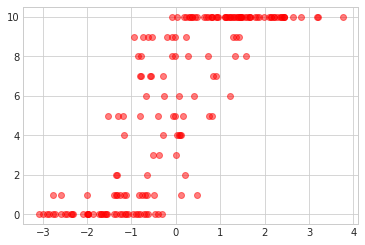

In [47]:
plt.scatter(x, y, c='r', alpha=0.5, cmap='viridis')

In [50]:
print(x)

[1.4491434, -0.023200989, 0.28126335, 0.91070414, 2.3638272, 0.7217188, 0.800241, 1.2422233, 1.3569245, -0.09773302, 0.36956453, 0.025249958, -2.592021, -0.73484755, -0.63732576, -0.8019438, -0.80951405, -0.08105087, 3.2127762, 1.1203008, 1.6663187, 1.8777409, 1.7862699, 1.9945986, 2.1443076, 1.4275537, -2.7631192, 2.2174704, 2.2839406, 1.6457596, 2.431465, 1.435988, 1.5951843, 1.2833138, 2.105629, 3.7660708, 2.442917, 2.4422157, 2.8314629, -0.76299095, -1.2691302, 1.2178807, -0.80968094, -0.72272825, -0.6522231, -0.6273775, 1.1048613, 0.8155594, 0.35423994, -0.02423811, 0.41170502, -0.2821579, -1.3391104, -0.9470701, 0.027021408, 2.15443, -0.25861454, 1.2005744, -0.8633528, -0.06484079, 0.17839956, 1.1126032, 0.120004654, 0.005915642, -0.3194232, 0.73271084, -0.6550927, -3.0039234, -2.589075, -2.8553076, -2.9087267, -2.7606182, -2.7219582, 0.814229, -1.2623558, 0.0657773, 1.1632376, 0.7483201, 0.9071665, -1.9850793, -1.3994379, 2.4030461, 0.46852064, 1.312717, 1.667162, 1.2180438, -1.

In [51]:
print(y)

[10, 9, 8, 7, 10, 10, 10, 10, 10, 10, 10, 4, 1, 9, 9, 7, 5, 9, 10, 10, 10, 10, 10, 10, 10, 9, 0, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 1, 1, 6, 0, 0, 1, 0, 10, 5, 10, 5, 6, 7, 0, 9, 10, 10, 6, 10, 8, 5, 10, 10, 4, 3, 0, 8, 2, 0, 0, 0, 0, 1, 0, 10, 0, 4, 10, 5, 10, 0, 1, 10, 10, 10, 10, 10, 0, 10, 10, 10, 9, 10, 8, 1, 1, 5, 0, 1, 0, 0, 0, 10, 10, 10, 7, 1, 0, 0, 0, 4, 10, 10, 3, 7, 0, 1, 5, 0, 0, 0, 8, 10, 0, 5, 5, 0, 0, 10, 9, 7, 10, 0, 0, 1, 0, 5, 1, 4, 6, 10, 10, 9, 3, 6, 8, 10, 9, 8, 2, 10, 4, 0, 0, 0, 2, 2, 7, 10, 10, 10, 10, 10, 0, 1, 0, 1, 1, 8, 0, 0, 0, 0, 0, 0]
